
# **Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [277]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Load data set

In [81]:
car_images = glob.glob('./vehicles/**/*.png')
notcar_images = glob.glob('./non-vehicles/**/*.png')

Car_num = len(car_images)
NotCar_num = len(notcar_images)

print("The number of Car samples is %d"% Car_num)
print("The number of Non-Car samples is %d" % NotCar_num)

The number of Car samples is 8792
The number of Non-Car samples is 8968


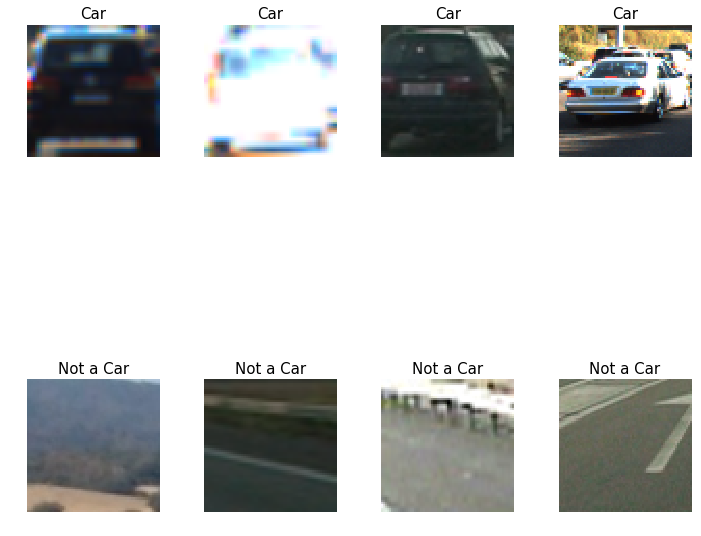

In [82]:
fig, axs = plt.subplots(2, 4, figsize=(10, 10))
axs = axs.ravel()
fig.tight_layout()

for index in range(4):
    img = mpimg.imread(car_images[np.random.randint(0, Car_num)])
    axs[index].axis('off')
    axs[index].set_title('Car', fontsize = 15)
    axs[index].imshow(img)
    
    img = mpimg.imread(notcar_images[np.random.randint(0,NotCar_num)])
    axs[index+4].axis('off')
    axs[index+4].set_title('Not a Car', fontsize = 15)
    axs[index+4].imshow(img)

## Histogram of oriented gradient

The [scikit-image](http://scikit-image.org/) package has a built in function to extract Histogram of Oriented Gradient features. The documentation for this function can be found [here](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog) and a brief explanation of the algorithm and tutorial can be found [here](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

The scikit-image hog() function takes in **a single color channel or grayscaled image** as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.

The number of **orientations** is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The **pixels_per_cell** parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are commonly chosen to be square.

The **cells_per_block** parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

There is another optional power law or "gamma" normalization scheme set by the flag **transform_sqrt**. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if your image contains negative values (because it's taking the square root of image values).

---
This is where things get a little confusing though. Let's say you are computing HOG features for an image like the one shown above that is 64×64 pixels. If you set pixels_per_cell=(8, 8) and cells_per_block=(2, 2) and orientations=9. How many elements will you have in your HOG feature vector for the entire image?

You might guess the number of orientations times the number of cells, or $9×8×8=576$, but that's not the case if you're using block normalization! In fact, the HOG features for all cells in each block are computed at each block position and the block steps across and down through the image cell by cell.

So, the actual number of features in your final feature vector will be the total number of block positions multiplied by the number of cells per block, times the number of orientations, or in the case shown above: 7$×7×2×2×9=1764$.

In [183]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# color convert
def conv_color(image, color_space='BGR'):
    freature_image=None
    # apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    print(imgs)
    print(color_space, hog_channel, spatial_feat)
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                print(feature_image.shape)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            print(len(file_features))
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Visualize HOG Features on Sample Images

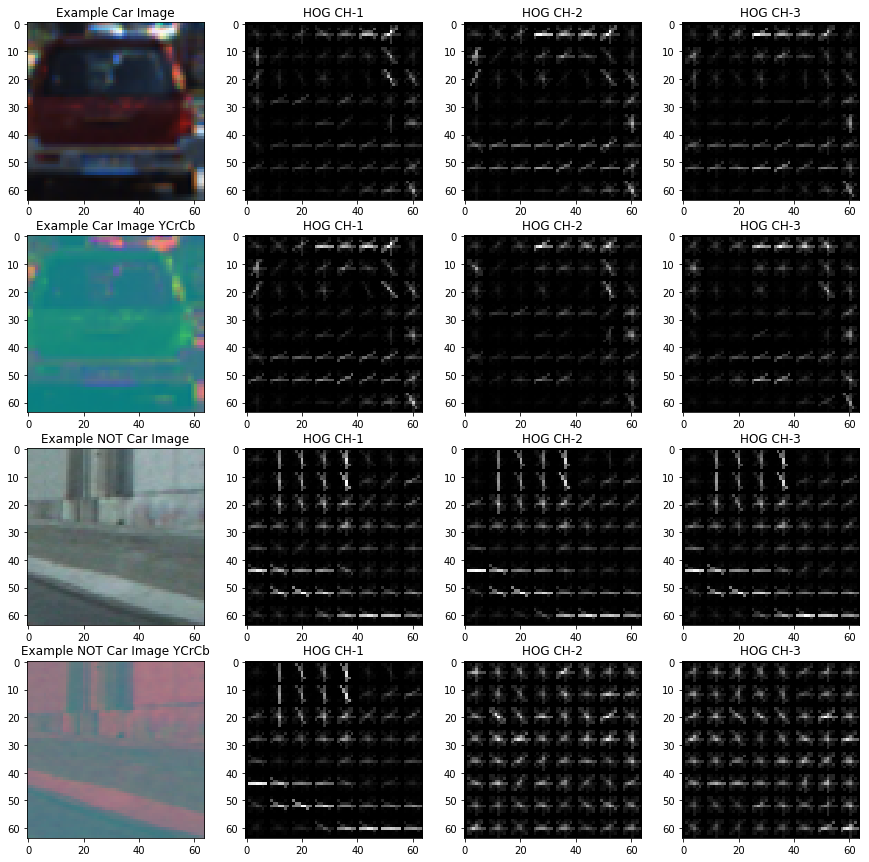

In [101]:
img_car = mpimg.imread(car_images[np.random.randint(0, Car_num)])
img_notcar = mpimg.imread(notcar_images[np.random.randint(0,NotCar_num)])

orient = 8

# car HOG on RGB color space.
# Call our function with vis=True to see an image output
_, hog_car_chan0 = get_hog_features(img_car[:, :, 0], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_car_chan1 = get_hog_features(img_car[:, :, 1], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_car_chan2 = get_hog_features(img_car[:, :, 2], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

f, ((ax1, ax2, ax3, ax4),(ax11, ax22, ax33, ax44),(ax111, ax222, ax333, ax444),(ax1111, ax2222, ax3333, ax4444)) = plt.subplots(4, 4, figsize=(15,15))
ax1.imshow(img_car, cmap='gray')
ax1.set_title('Example Car Image')
ax2.imshow(hog_car_chan0, cmap='gray')
ax2.set_title('HOG CH-1')
ax3.imshow(hog_car_chan1, cmap='gray')
ax3.set_title('HOG CH-2')
ax4.imshow(hog_car_chan2, cmap='gray')
ax4.set_title('HOG CH-3')


#  car HOG on YCB
car_ycb = cv2.cvtColor(img_car, cv2.COLOR_RGB2YCrCb)

_, hog_car_chan0 = get_hog_features(car_ycb[:, :, 0], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_car_chan1 = get_hog_features(car_ycb[:, :, 1], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_car_chan2 = get_hog_features(car_ycb[:, :, 2], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

ax11.imshow(car_ycb, cmap='gray')
ax11.set_title('Example Car Image YCrCb')
ax22.imshow(hog_car_chan0, cmap='gray')
ax22.set_title('HOG CH-1')
ax33.imshow(hog_car_chan1, cmap='gray')
ax33.set_title('HOG CH-2')
ax44.imshow(hog_car_chan2, cmap='gray')
ax44.set_title('HOG CH-3')


#  not car HOG on RBG
_, hog_ncar_chan0 = get_hog_features(img_notcar[:, :, 0], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_ncar_chan1 = get_hog_features(img_notcar[:, :, 1], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_ncar_chan2 = get_hog_features(img_notcar[:, :, 2], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

ax111.imshow(img_notcar, cmap='gray')
ax111.set_title('Example NOT Car Image')
ax222.imshow(hog_ncar_chan0, cmap='gray')
ax222.set_title('HOG CH-1')
ax333.imshow(hog_ncar_chan1, cmap='gray')
ax333.set_title('HOG CH-2')
ax444.imshow(hog_ncar_chan2, cmap='gray')
ax444.set_title('HOG CH-3')


#  not car HOG on YCB
ncar_ycb = cv2.cvtColor(img_notcar, cv2.COLOR_RGB2YCrCb)
_, hog_ncar_chan0 = get_hog_features(ncar_ycb[:, :, 0], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_ncar_chan1 = get_hog_features(ncar_ycb[:, :, 1], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
_, hog_ncar_chan2 = get_hog_features(ncar_ycb[:, :, 2], orient, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)

ax1111.imshow(ncar_ycb, cmap='gray')
ax1111.set_title('Example NOT Car Image YCrCb')
ax2222.imshow(hog_ncar_chan0, cmap='gray')
ax2222.set_title('HOG CH-1')
ax3333.imshow(hog_ncar_chan1, cmap='gray')
ax3333.set_title('HOG CH-2')
ax4444.imshow(hog_ncar_chan2, cmap='gray')
ax4444.set_title('HOG CH-3')

plt.savefig('./examples/HOG_test_8')

## Bin Spatial Function

In [85]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

Text(0.5,1,'Not Car Spatial Features')

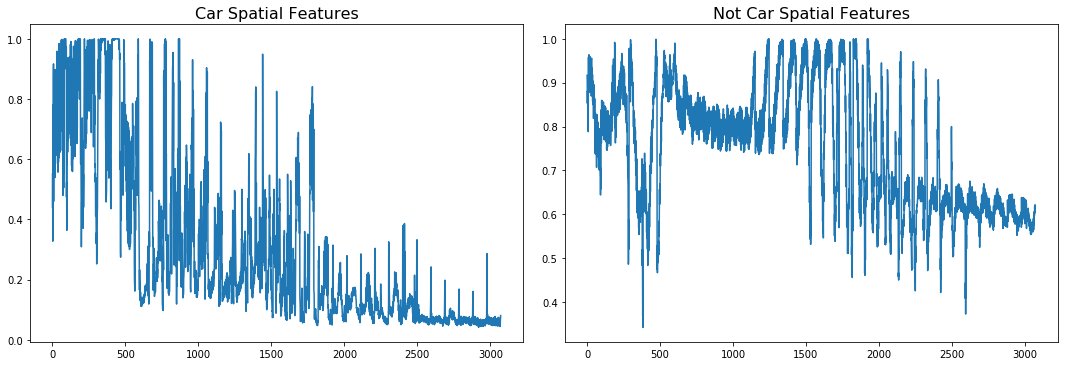

In [86]:
car_spatial = bin_spatial(img_car)
not_car_spatial = bin_spatial(img_notcar)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()

ax1.plot(car_spatial)
ax1.set_title("Car Spatial Features", fontsize=16)
ax2.plot(not_car_spatial)
ax2.set_title("Not Car Spatial Features", fontsize=16)


## Color Histogram Function
With np.histogram(), you don't actually have to specify the number of bins or the range, but here I've arbitrarily chosen 32 bins and specified range=(0, 256) in order to get orderly bin sizes. np.histogram() returns a tuple of two arrays. In this case, for example, rhist[0] contains the counts in each of the bins and rhist[1] contains the bin edges (so it is one element longer than rhist[0]).

In [90]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)#, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)#, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)#, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

(96,) (64, 64, 3)


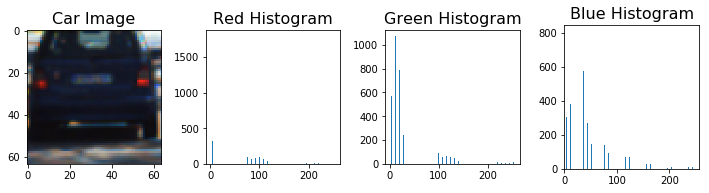

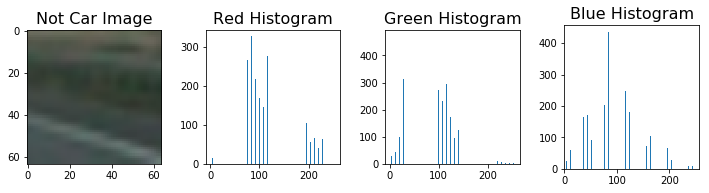

In [91]:

img_car = mpimg.imread(car_images[np.random.randint(0, Car_num)])
img_notcar = mpimg.imread(notcar_images[np.random.randint(0,NotCar_num)])

car_color_hist = color_hist(img_car)
non_car_color_hist = color_hist(img_notcar)

print(car_color_hist.shape, img_car.shape)

car_rh = car_color_hist[:32]
car_gh = car_color_hist[32:64]
car_bh = car_color_hist[64:]

non_car_rh = non_car_color_hist[:32]
non_car_gh = non_car_color_hist[32:64]
non_car_bh = non_car_color_hist[64:]

bin_edges = np.histogram(img_car[:,:0], bins=32, range=(0,256))[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2

def display_color_hist(img1, img2, img3, img4, img1_title, img2_title, img3_title, img4_title, bin_centers):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 10))
    plt.xlim(0,256)
    
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(img1_title, fontsize=16)
    ax2.bar(bin_centers, img2)
    asp2 = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp2)
    ax2.set_title(img2_title, fontsize=16)
    ax3.bar(bin_centers, img3)
    asp3 = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
    ax3.set_aspect(asp3)
    ax3.set_title(img3_title, fontsize=16)
    ax4.bar(bin_centers, img4)
    asp4 = np.diff(ax3.get_xlim())[0] / np.diff(ax4.get_ylim())[0]
    ax4.set_aspect(asp4)
    ax4.set_title(img4_title, fontsize=16)

display_color_hist(img_car, car_rh, car_gh, car_bh, "Car Image", "Red Histogram", "Green Histogram", "Blue Histogram", bin_centers)    
display_color_hist(img_notcar, non_car_rh, non_car_gh, non_car_bh, "Not Car Image", "Red Histogram", "Green Histogram", "Blue Histogram", bin_centers)

## Extracting Features From Training Set

In [139]:
color_space = 'YCrCb'
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print('Extracting features...')
t1=time.time()
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract features...')
print(len(car_features))
print(len(notcar_features))

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

Extracting features...
117.37 Seconds to extract features...
8792
8968
Using: 16 orientations 8 pixels per cell and 2 cells per block


## Training

In [226]:
# Datatype is float64 because of Standarscaler
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Label 
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

# Data splitting
rand_state = np.random.randint(0,100)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = rand_state)


X_scaler = StandardScaler().fit(X_train)
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

svc = LinearSVC()
svc.fit(scaled_X_train,y_train)
print('test accuracy of SVC:', svc.score(scaled_X_test,y_test))
## Predictions

print('My SVC predicts: ', svc.predict(scaled_X_test[0:10]))
print('For Labels: ',y_test[0:10])

test accuracy of SVC: 0.989301801802
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]
For Labels:  [ 0.  0.  1.  0.  1.  1.  0.  0.  0.  0.]


## Find cars

In [227]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, color_space, scale, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: 
        ctrans_tosearch = np.copy(img_tosearch)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == "ALL":
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            else: 
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

15 possible cars


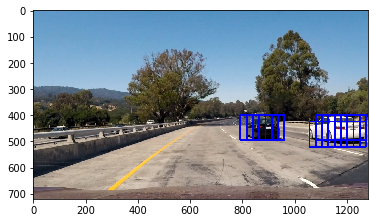

In [291]:
ystart = 400
ystop = 656
scale = 1.5
test_image = mpimg.imread('./test_images/test1.jpg')
ret_img, bboxes = find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(len(bboxes), 'possible cars')
rect_on_image = draw_boxes(test_image,bboxes)
plt.imshow(rect_on_image)

plt.savefig('./examples/sliding_windows.jpg')

## Sliding Window

In [229]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='BGR', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    print(spatial_feat)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        print(features.shape, features)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Filter: heatmap and threshold

In [230]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Calculate slide window

In [240]:
# apply the pipeline to example image
test_imgs = sorted(glob.glob('./test_images/*.jpg'))
# region of interest is ((0, 450), (1280, 720))
ystart = 400
ystop = 660
scale = 1
threshold = 3
# known parameters
# svc, Xscaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins
idx = 1
plt.figure(figsize=(16,8))
row = (len(test_imgs) - 1) / 3 + 1
print("current colorspace: {}".format(color_space))
image = mpimg.imread(test_imgs[0])

overlap = 0.8
# left side
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, ystop], 
                    xy_window=(180, 180), xy_overlap=(overlap, overlap))
# right side
#windows1 += slide_window(image, x_start_stop=[1000, None], y_start_stop=[ystart, ystop], 
#                    xy_window=(128, 128), xy_overlap=(ov, ov))
# center(far)
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 600], 
                    xy_window=(150, 150), xy_overlap=(overlap, overlap))    
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 550], 
                    xy_window=(120, 120), xy_overlap=(overlap, overlap)) 
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 500], 
                    xy_window=(80, 80), xy_overlap=(overlap, overlap)) 
windows1 += slide_window(image, x_start_stop=[None, None], y_start_stop=[ystart, 500], 
                    xy_window=(64, 64), xy_overlap=(overlap, overlap)) 
windows = windows1


current colorspace: YCrCb


<Figure size 1152x576 with 0 Axes>

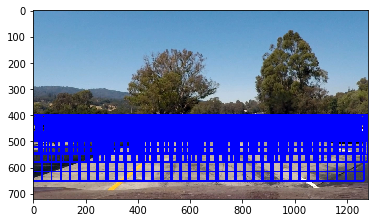

In [243]:

small_search_windows = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
plt.imshow(small_search_windows)
plt.show()

In [298]:
def apply_sliding_window(test_image):
    bboxes = []
    ystart = 400
    ystop = 500
    scale = 1
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 400
    ystop = 500
    scale = 1.3
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 410
    ystop = 500
    scale = 1.4
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 420
    ystop = 556
    scale = 1.6
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 430
    ystop = 556
    scale = 1.8
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystop = 556
    scale = 2.0
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 440
    ystop = 556
    scale = 2.3
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 400
    ystop = 556
    scale = 1.3
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 400
    ystop = 556
    scale = 2.2
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    ystart = 500
    ystop = 656
    scale = 3.0
    bboxes.append(find_cars(test_image, ystart, ystop, color_space, scale, hog_channel, svc,X_scaler, orient, 
                                pix_per_cell, cell_per_block, spatial_size, hist_bins)[1])
    return bboxes

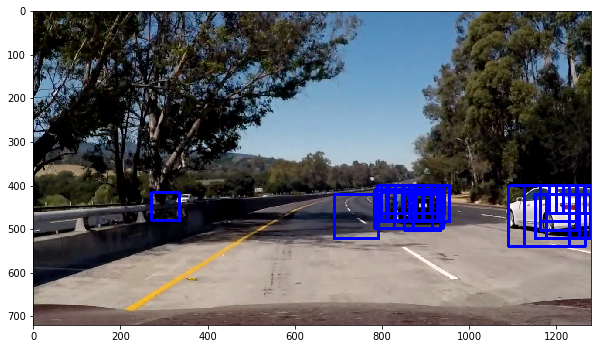

In [300]:
test_image = mpimg.imread('./test_images/test5.jpg')
bboxes = apply_sliding_window(test_image)
bboxes = [item for sublist in bboxes for item in sublist]
rects_on_image = draw_boxes(test_image, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(rects_on_image)

plt.savefig('./examples/sliding_window.jpg')

2 cars found


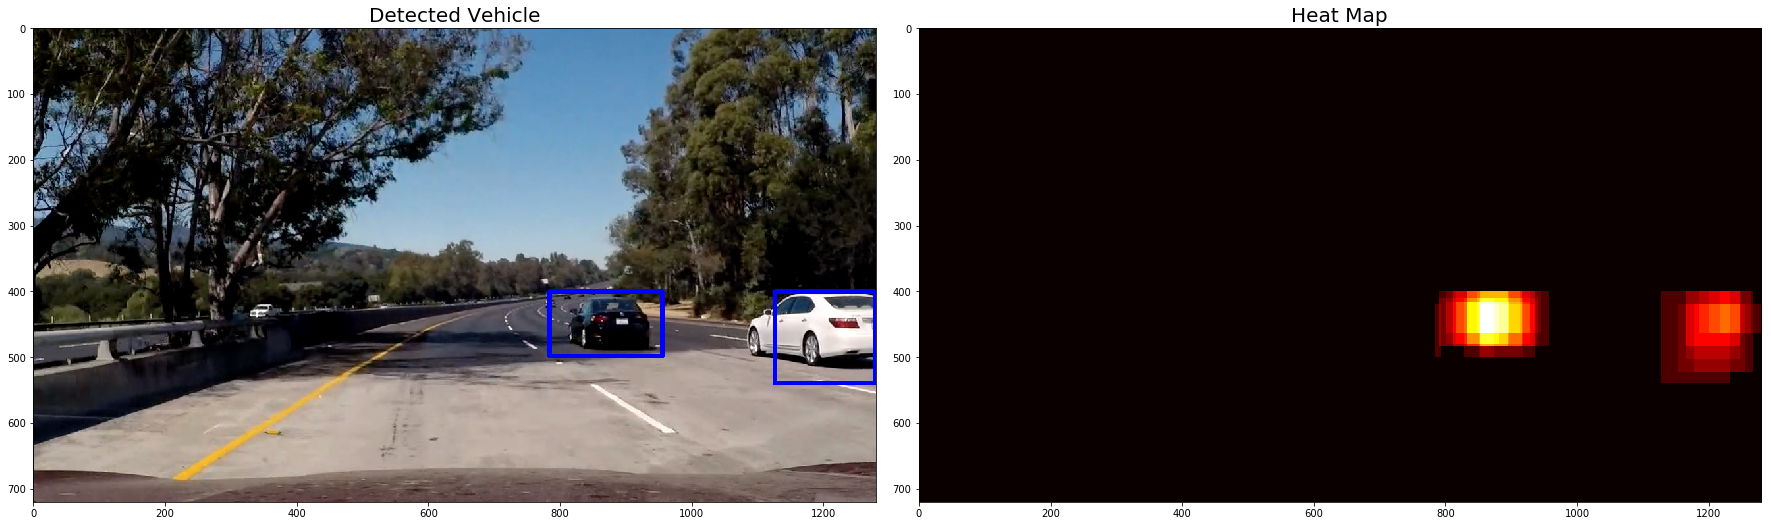

In [301]:

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,rectangles) 
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Detected Vehicle', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline

In [288]:
def pipeline(image):
    bboxes = apply_sliding_window(image)
    bboxes = [item for sublist in bboxes for item in sublist]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)   
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat,2)#1 + len(vehdet.prev_rects)//2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap

## Visualization

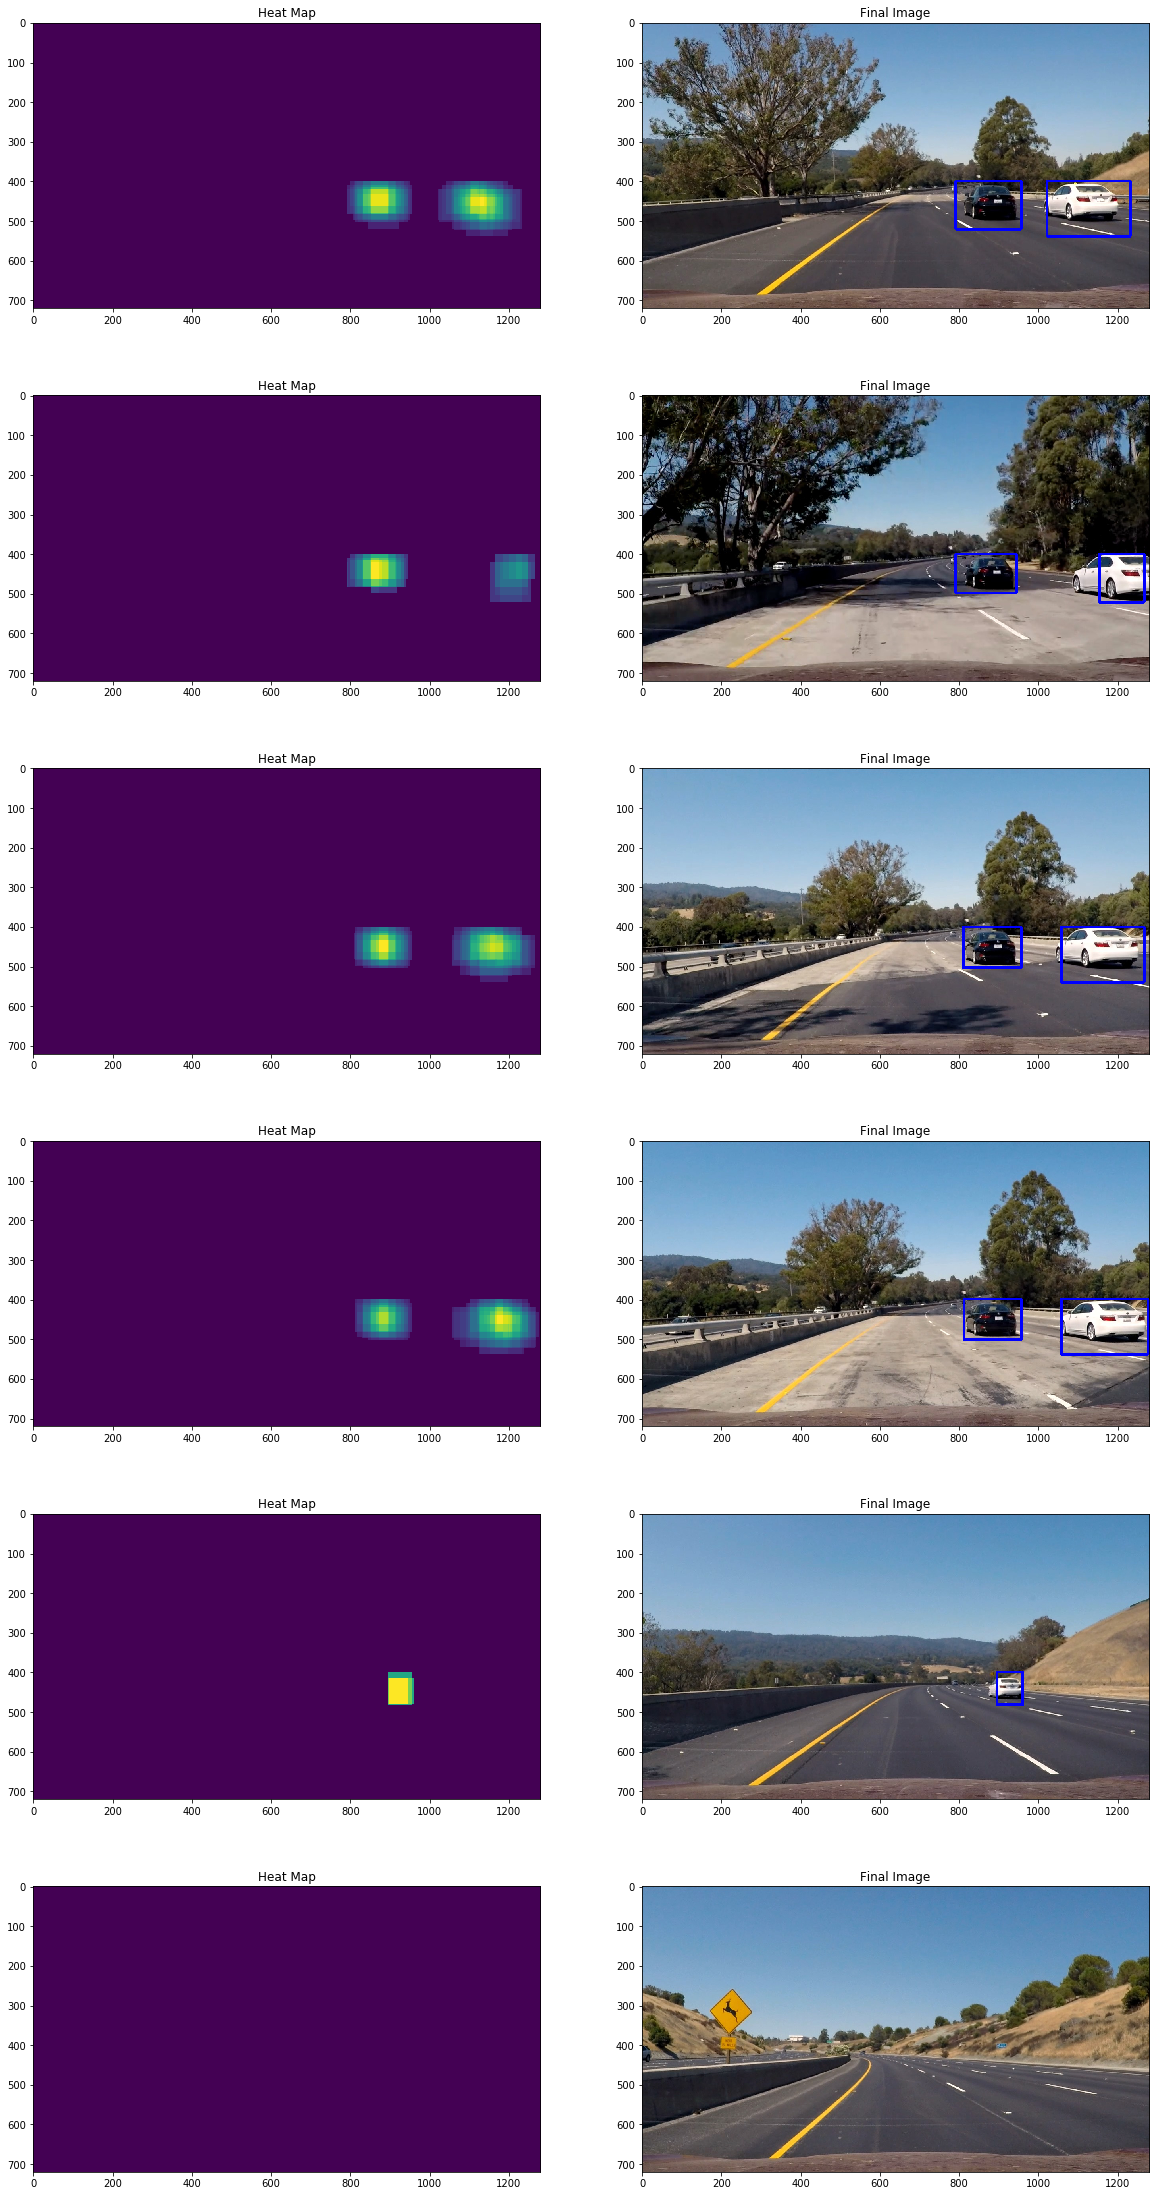

In [302]:
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(6,2, figsize=(20,40))
for index,image in enumerate(test_images):
    image = mpimg.imread(image)
    resultPic,heat_img = pipeline(image)
    axes[index,0].imshow(heat_img)
    axes[index,0].set_title("Heat Map")
    axes[index,1].imshow(resultPic)
    axes[index,1].set_title("Final Image")

plt.savefig('./examples/bboxes_and_heat')

## Final output

In [303]:
pre_frame_bboxes = []
def final_output(image):
    global pre_frame_bboxes
    boxes = apply_sliding_window(image)
    boxes = [item for sublist in boxes for item in sublist]
    if len(boxes)>0:
        pre_frame_bboxes.append(boxes)
    if len(pre_frame_bboxes) > 10:
        pre_frame_bboxes = pre_frame_bboxes[len(pre_frame_bboxes)-10:]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)    
    for box in pre_frame_bboxes:
        heat = add_heat(heat, box)
    heat = apply_threshold(heat,12)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

video = './project_video.mp4'
video_output = 'out_video.mp4'
clip2 = VideoFileClip(video)
out_clip = clip2.fl_image(final_output) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


100%|█████████▉| 1260/1261 [31:11<00:01,  1.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_video.mp4 

CPU times: user 1h 9min 5s, sys: 2min 57s, total: 1h 12min 2s
Wall time: 31min 12s
